In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd 
from IPython.display import display, HTML
import html # Import the standard 'html' library

FOLDER_PATH = "../../../../../../../data/rrochas/raw_data/Manhattan"
SAVE_PATH = "../../../../data/rrochas/prediction_validation/Manhattan"

# # --- Load gdf: 
# remote_df = pd.read_excel(f'{FOLDER_PATH}/Remote-Booth-Station.xls', index_col=0) 
# gdf = gpd.read_file(f'{SAVE_PATH}/subway_stations.shp',crs = 'EPSG:4326',index_col=0)
# gdf= gdf[['GTFS Stop', 'Station ID', 'Complex ID','Borough','Structure','GTFS Latit','GTFS Longi','geometry']]

# --- Load MTA data 
# MTA_raw = pd.read_csv(f'{FOLDER_PATH}/MTA_Subway_Hourly_Ridership__2020-2024_20250813.csv') # 49 M lignes  OK 
# MTA_raw = pd.read_csv(f'{FOLDER_PATH}/MTA_Subway_Hourly_Ridership__2020-2024_20251204.csv') # Does not work 
MTA_raw = pd.read_csv(f'{FOLDER_PATH}/MTA_Turnstile_Manhattan_2022_2023.csv') #  OK


# Two Ways of filtering Manhattan Stations (totally different results):

In [3]:
# --- Restrict to Manhattan: 
# df_manhattan_raw = MTA_raw[MTA_raw['station_complex_id'].isin(gdf['Complex ID'])]
df_manhattan_raw = MTA_raw[MTA_raw['borough'] == 'Manhattan'] # Alternative way to filter manhattan 
df_manhattan_raw['station_complex_id'] = df_manhattan_raw['station_complex_id'].astype(str)
print(f'df_manhattan: (size: {len(df_manhattan_raw)})')
display(df_manhattan_raw.head())

df_manhattan: (size: 7422844)


,transit_timestamp,transit_mode,station_complex_id,station_complex,borough,payment_method,fare_class_category,ridership,transfers,latitude,longitude,georeference
0,2022-01-01T00:00:00.000,subway,440,"116 St (2,3)",Manhattan,metrocard,Metrocard - Seniors & Disability,2.0,0.0,40.802097,-73.949620,"{'type': 'Point', 'coordinates': [-73.94962, 4..."
1,2022-01-01T00:00:00.000,subway,409,Spring St (6),Manhattan,metrocard,Metrocard - Unlimited 7-Day,13.0,0.0,40.722300,-73.997140,"{'type': 'Point', 'coordinates': [-73.99714, 4..."
2,2022-01-01T00:00:00.000,subway,635,"South Ferry (1)/Whitehall St (R,W)",Manhattan,metrocard,Metrocard - Seniors & Disability,5.0,0.0,40.702070,-74.013664,"{'type': 'Point', 'coordinates': [-74.013664, ..."
3,2022-01-01T00:00:00.000,subway,314,66 St-Lincoln Center (1),Manhattan,omny,OMNY - Full Fare,64.0,0.0,40.773440,-73.982210,"{'type': 'Point', 'coordinates': [-73.98221, 4..."
4,2022-01-01T00:00:00.000,subway,609,"Bryant Pk (B,D,F,M)/5 Av (7)",Manhattan,metrocard,Metrocard - Seniors & Disability,7.0,0.0,40.754223,-73.981964,"{'type': 'Point', 'coordinates': [-73.981964, ..."


# Visualisation of flow per stations: 

In [4]:

gdf_from_flows = gpd.GeoDataFrame(df_manhattan_raw.groupby('station_complex_id').agg({'latitude': 'first',
                                                                                      'longitude': 'first',
                                                                                      'ridership': 'sum',
                                                                                      })
                                                                                      )
gdf_from_flows = gdf_from_flows.set_geometry(gpd.points_from_xy(gdf_from_flows.longitude, gdf_from_flows.latitude))
gdf_from_flows.crs = 'EPSG:4326'

gdf_from_flows['ridership_100k'] = gdf_from_flows['ridership'] / 1000000

m = gdf_from_flows.explore('ridership_100k',
        tiles = 'CartoDB positron', 
        marker_type = 'circle',
        style_kwds={'style_function': lambda x: {'radius': np.sqrt(x['properties']['ridership'])/30},
                        'cmap': 'viridis',
                        'fill': True,
                    },
        legend_kwds={'caption': 'Ridership in Millions'}
        )

map_html_string = m._repr_html_()
escaped_map_html = html.escape(map_html_string, quote=True)
iframe_html = f'<iframe srcdoc="{escaped_map_html}" width="{800}" height="{400}" style="border:none;"></iframe>'
display(HTML(iframe_html))
print('Number of plotted complex IDs:', len(gdf_from_flows))

/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/IPython/core/display.py:431: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


Number of plotted complex IDs: 123


# Analysis number of covered dates : 

In [9]:
# Convert datetime :
df_manhattan = df_manhattan_raw.copy()

# If input is from MTA_Subway_Hourly_Ridership__2020-2024_20250813.csv:
# Format: '01/01/2022 12:00:00 AM'
if False: 
    df_manhattan['transit_timestamp'] = pd.to_datetime(df_manhattan['transit_timestamp'], 
                                                    format='%m/%d/%Y %I:%M:%S %p',
                                                    errors='coerce')
# if input is from MTA_Turnstile_Manhattan_2022_2023.csv:
# Format: '2022-01-01T00:00:00.000'
if True: 
    df_manhattan['transit_timestamp'] = pd.to_datetime(df_manhattan['transit_timestamp'], 
                                                    format='%Y-%m-%dT%H:%M:%S.%f',
                                                    errors='coerce')
                                                    

print('df_manhattan after transformed datetime: ')
display(df_manhattan.head())

df_manhattan after transformed datetime: 


,transit_timestamp,transit_mode,station_complex_id,station_complex,borough,payment_method,fare_class_category,ridership,transfers,latitude,longitude,georeference
0,2022-01-01,subway,440,"116 St (2,3)",Manhattan,metrocard,Metrocard - Seniors & Disability,2.0,0.0,40.802097,-73.949620,"{'type': 'Point', 'coordinates': [-73.94962, 4..."
1,2022-01-01,subway,409,Spring St (6),Manhattan,metrocard,Metrocard - Unlimited 7-Day,13.0,0.0,40.722300,-73.997140,"{'type': 'Point', 'coordinates': [-73.99714, 4..."
2,2022-01-01,subway,635,"South Ferry (1)/Whitehall St (R,W)",Manhattan,metrocard,Metrocard - Seniors & Disability,5.0,0.0,40.702070,-74.013664,"{'type': 'Point', 'coordinates': [-74.013664, ..."
3,2022-01-01,subway,314,66 St-Lincoln Center (1),Manhattan,omny,OMNY - Full Fare,64.0,0.0,40.773440,-73.982210,"{'type': 'Point', 'coordinates': [-73.98221, 4..."
4,2022-01-01,subway,609,"Bryant Pk (B,D,F,M)/5 Av (7)",Manhattan,metrocard,Metrocard - Seniors & Disability,7.0,0.0,40.754223,-73.981964,"{'type': 'Point', 'coordinates': [-73.981964, ..."


In [11]:
#  Let's count that kind of 'row' with the same 'transit_timestamp':

# Example row:
# transit_timestamp                  2022-12-14 13:00:00
# transit_mode                                    subway
# station_complex_id                                 610
# [...]
# ridership                                          4.0
# Georeference              POINT (-73.976845 40.751778)
# Name: 1, dtype: object
collected_per_hours =  df_manhattan.transit_timestamp.value_counts()
display(collected_per_hours.head())

transit_timestamp
2022-03-03 18:00:00    1090
2022-03-03 19:00:00    1089
2022-03-03 17:00:00    1080
2022-02-23 18:00:00    1074
2022-12-09 17:00:00    1072
Name: count, dtype: int64

In [12]:
# --- Reindex to have continuous hourly index
start = collected_per_hours.index.min()
end = collected_per_hours.index.max()
collected_per_hours = collected_per_hours.reindex(pd.date_range(start=start, end=end, freq='H')).fillna(0)
display(collected_per_hours.head())

/tmp/ipykernel_82807/121751451.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  collected_per_hours = collected_per_hours.reindex(pd.date_range(start=start, end=end, freq='H')).fillna(0)


2022-01-01 00:00:00    767.0
2022-01-01 01:00:00    733.0
2022-01-01 02:00:00    663.0
2022-01-01 03:00:00    584.0
2022-01-01 04:00:00    575.0
Freq: h, Name: count, dtype: float64

In [13]:
# --- Reset index and extract date features
df = collected_per_hours.reset_index()
df['day'] = df['index'].dt.day_name()
df['week_year'] = df['index'].dt.strftime('%Y-%U')
display(df.head())

,index,count,day,week_year
0,2022-01-01 00:00:00,767.0,Saturday,2022-00
1,2022-01-01 01:00:00,733.0,Saturday,2022-00
2,2022-01-01 02:00:00,663.0,Saturday,2022-00
3,2022-01-01 03:00:00,584.0,Saturday,2022-00
4,2022-01-01 04:00:00,575.0,Saturday,2022-00


In [14]:
# 1. Group df by (week_year, dayofweek)
#  and 
# 2. aggregated with 'sum' 
#  to get total counts of hourly aggregated records per day (idenfied by a tuple [week_year, dayofweek])
df_grouped = df.groupby(['week_year','day']).agg({'count':'sum'}).reset_index()
display(df_grouped.head())
df_pivot = df_grouped.pivot(index='week_year', columns='day', values='count')
df_pivot = df_pivot[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]
display(df_pivot.head())

,week_year,day,count
0,2022-00,Saturday,18425.0
1,2022-01,Friday,20591.0
2,2022-01,Monday,20308.0
3,2022-01,Saturday,18660.0
4,2022-01,Sunday,18060.0


day,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
week_year,,,,,,,
2022-00,NaN,NaN,NaN,NaN,NaN,18425.0,NaN
2022-01,20308.0,20399.0,20422.0,20553.0,20591.0,18660.0,18060.0
2022-02,20386.0,20410.0,20531.0,20715.0,20765.0,18723.0,18300.0
2022-03,19981.0,20465.0,20660.0,20773.0,20734.0,18806.0,18241.0
2022-04,20530.0,20695.0,20715.0,20768.0,20893.0,18398.0,18382.0


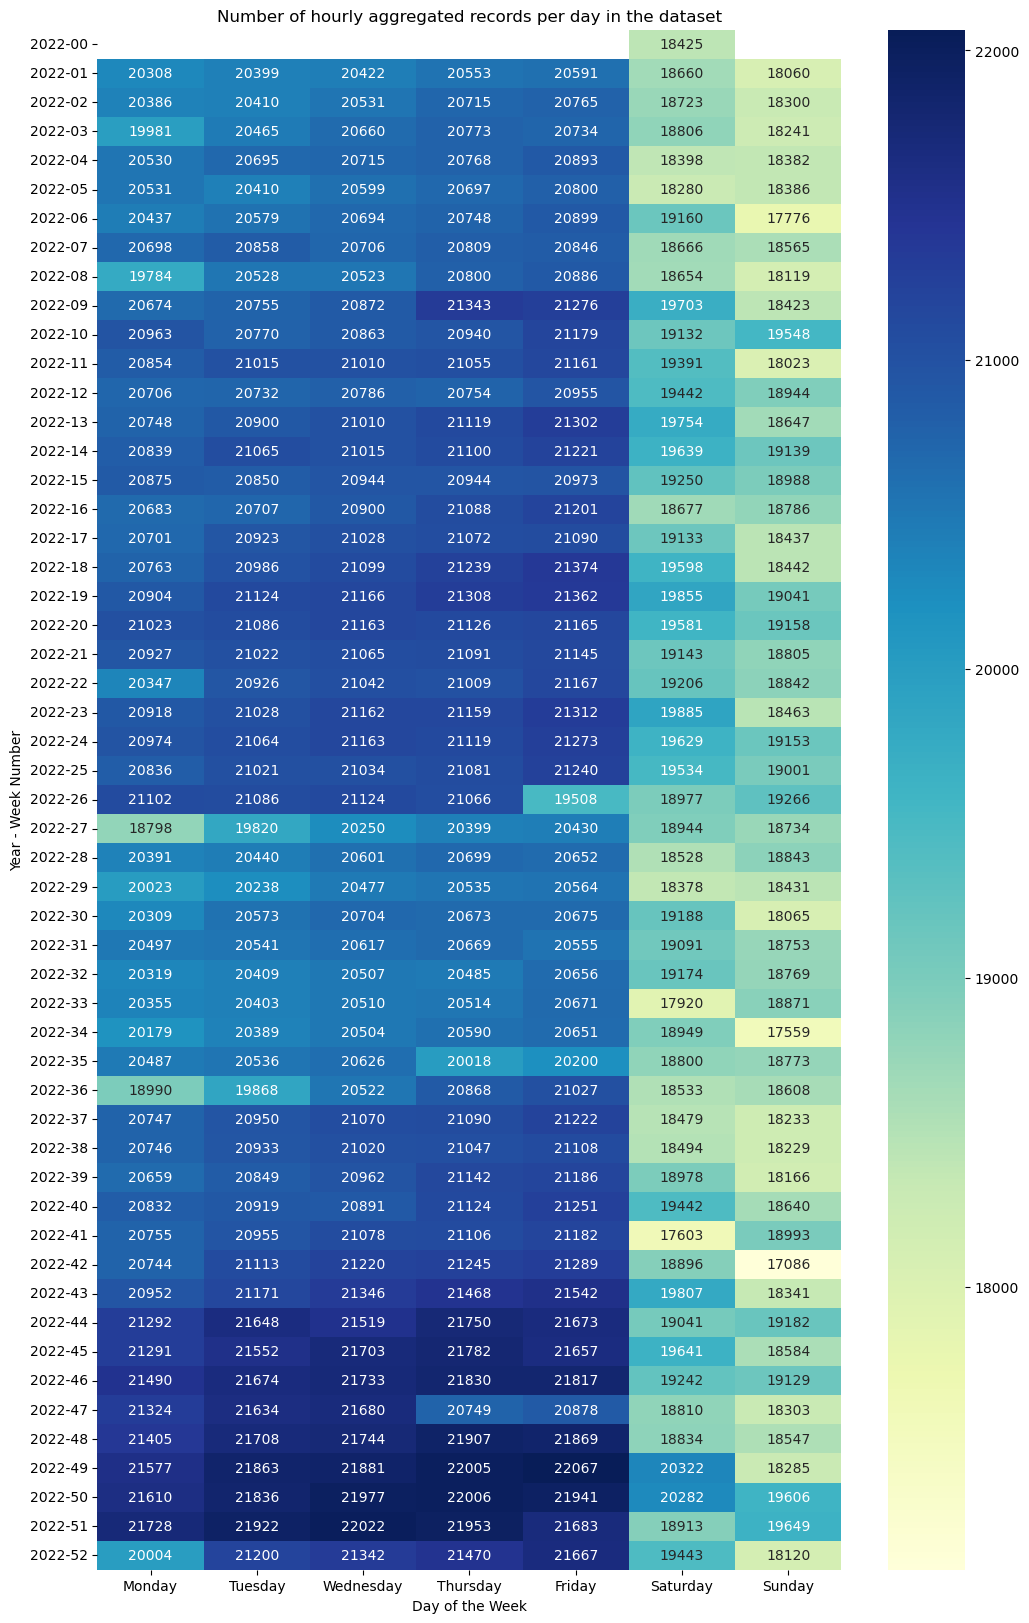

In [15]:
# Visualize samples per days with seaborn:
import seaborn as sns
import matplotlib.pyplot as plt

# 3. Plot heatmap
plt.figure(figsize=(12, 20))
sns.heatmap(df_pivot, cmap='YlGnBu', annot=True, fmt=".0f")
plt.title("Number of hourly aggregated records per day in the dataset")
plt.xlabel("Day of the Week")
plt.ylabel("Year - Week Number")
plt.show()


## Summed Ridership: 

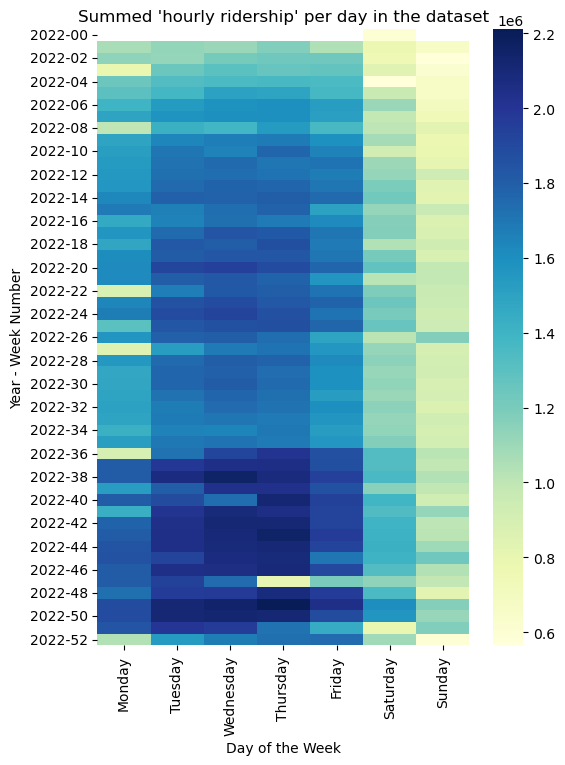

In [16]:


df_ridership = df_manhattan.set_index('transit_timestamp')[['ridership']]
df_ridership = df_ridership.resample('d').sum()
start = df_ridership.index.min()
end = df_ridership.index.max()
ridership_per_hours = df_ridership.reindex(pd.date_range(start=start, end=end, freq='d')).fillna(0)

df = ridership_per_hours.copy().reset_index()
df['day'] = df['index'].dt.day_name()
df['week_year'] = df['index'].dt.strftime('%Y-%U')
df_pivot = df.pivot(index='week_year', columns='day', values='ridership')
df_pivot = df_pivot[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]


plt.figure(figsize=(6, 8))
sns.heatmap(df_pivot, cmap='YlGnBu', 
            # annot=True,
            # fmt=".0f"
           )  # Set color bar format to scientific notation


plt.title("Summed 'hourly ridership' per day in the dataset")
plt.xlabel("Day of the Week")
plt.ylabel("Year - Week Number")
plt.savefig(f'/home/rrochas/prediction-validation/jupyter_ipynb/Load_Datasets/Manhattan/heatmap_ridership_per_day.png', bbox_inches='tight')
plt.show()


# Number of missing dates within Manhattan : 

Proportion of Complex IDs with more than 300 unique dates with ridership records:  100.00%


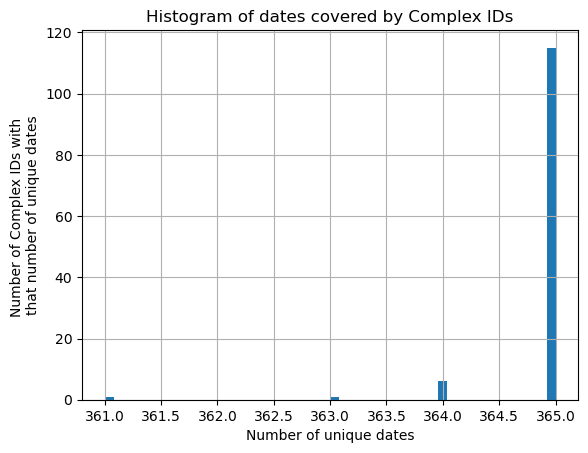

In [17]:
n_dates_per_stations =  df_manhattan.groupby('station_complex_id')['transit_timestamp'].apply(lambda s: len(s.dt.date.unique()))
n_dates_per_stations.hist(bins=50)
min_n_stations = 300
plt.title("Histogram of dates covered by Complex IDs")
plt.xlabel("Number of unique dates")
plt.ylabel("Number of Complex IDs with \nthat number of unique dates")
print(f'Proportion of Complex IDs with more than {min_n_stations} unique dates with ridership records: ', 
        '{:.2%}'.format((n_dates_per_stations > min_n_stations).sum() / len(n_dates_per_stations))
)


# Analysis from 9th - 39th week of 2022

Filtering data from  2022-03-05 00:00:00  to  2022-10-01 00:00:00


/tmp/ipykernel_82807/199398677.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_manhattan_filtered['date'] = df_manhattan_filtered['transit_timestamp'].dt.date
/tmp/ipykernel_82807/199398677.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_manhattan_filtered['hour'] = df_manhattan_filtered['transit_timestamp'].dt.hour


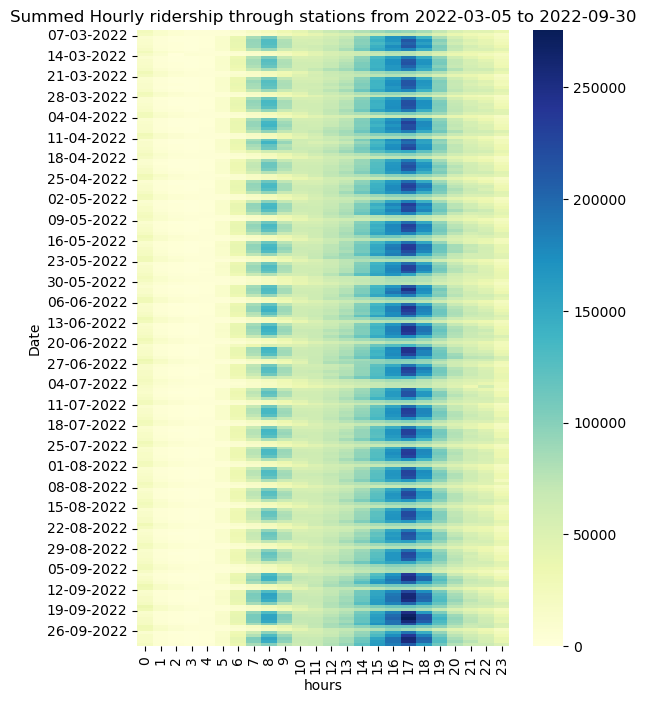

/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/IPython/core/display.py:431: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [18]:
from datetime import datetime, timedelta
# Analysis from 9th - 39th week of 2022

start = datetime(2022,1,1) + timedelta(weeks=9)
end = datetime(2022,1,1) + timedelta(weeks=39)
print('Filtering data from ', start, ' to ', end)

df_manhattan_filtered = df_manhattan[
    (df_manhattan['transit_timestamp'] >= start) & 
    (df_manhattan['transit_timestamp'] < end)
]

# --- Agg per date,hour: 
df_manhattan_filtered['date'] = df_manhattan_filtered['transit_timestamp'].dt.date
df_manhattan_filtered['hour'] = df_manhattan_filtered['transit_timestamp'].dt.hour
df_ridership = df_manhattan_filtered.groupby(['date','hour']).agg({'ridership':'sum'}).reset_index()
df_pivot = df_ridership.pivot(index='date', columns='hour', values='ridership')

start = df_pivot.index.min()
end = df_pivot.index.max()
df_pivot = df_pivot.reindex(pd.date_range(start=start, end=end, freq='D')).fillna(0)
df_pivot = df_pivot[list(np.arange(0,24))]
df_pivot.index = df_pivot.index.strftime('%d-%m-%Y')

plt.figure(figsize=(6, 8))
sns.heatmap(df_pivot, cmap='YlGnBu', annot=False,
           )  # Set color bar format to scientific notation

# display only first ticks related to monday on y-axis:
y_ticks = []
for i, date_str in enumerate(df_pivot.index):
    date_obj = datetime.strptime(date_str, '%d-%m-%Y')
    if date_obj.weekday() == 0:  # Monday
        y_ticks.append(i)
plt.yticks(ticks=y_ticks, labels=[df_pivot.index[i] for i in y_ticks], rotation=0)
plt.title(f"Summed Hourly ridership through stations from {start.strftime('%Y-%m-%d')} to {end.strftime('%Y-%m-%d')}")
plt.xlabel("hours")
plt.ylabel("Date")
plt.savefig(f'/home/rrochas/prediction-validation/jupyter_ipynb/Load_Datasets/Manhattan/heatmap_hourly_ridership.png', bbox_inches='tight')
plt.show()
# ----- 


# --- Folium visualisation : 
gdf_from_flows = gpd.GeoDataFrame(df_manhattan_filtered.groupby('station_complex_id').agg({'latitude': 'first',
                                                                                      'longitude': 'first',
                                                                                      'ridership': 'sum',
                                                                                      })
                                                                                      )
gdf_from_flows = gdf_from_flows.set_geometry(gpd.points_from_xy(gdf_from_flows.longitude, gdf_from_flows.latitude))
gdf_from_flows.crs = 'EPSG:4326'

gdf_from_flows['ridership_100k'] = gdf_from_flows['ridership'] / 1000000

m = gdf_from_flows.explore('ridership_100k',
        tiles = 'CartoDB positron', 
        marker_type = 'circle',
        style_kwds={'style_function': lambda x: {'radius': np.sqrt(x['properties']['ridership'])/30},
                        'cmap': 'viridis',
                        'fill': True,
                    },
        legend_kwds={'caption': 'Ridership in Millions'}
        )

map_html_string = m._repr_html_()
escaped_map_html = html.escape(map_html_string, quote=True)
iframe_html = f'<iframe srcdoc="{escaped_map_html}" width="{800}" height="{400}" style="border:none;"></iframe>'
display(HTML(iframe_html))


# Analysis from 1st Ocotbre - 9th december 2022  

Filtering data from  2022-10-01 00:00:00  to  2022-12-09 00:00:00


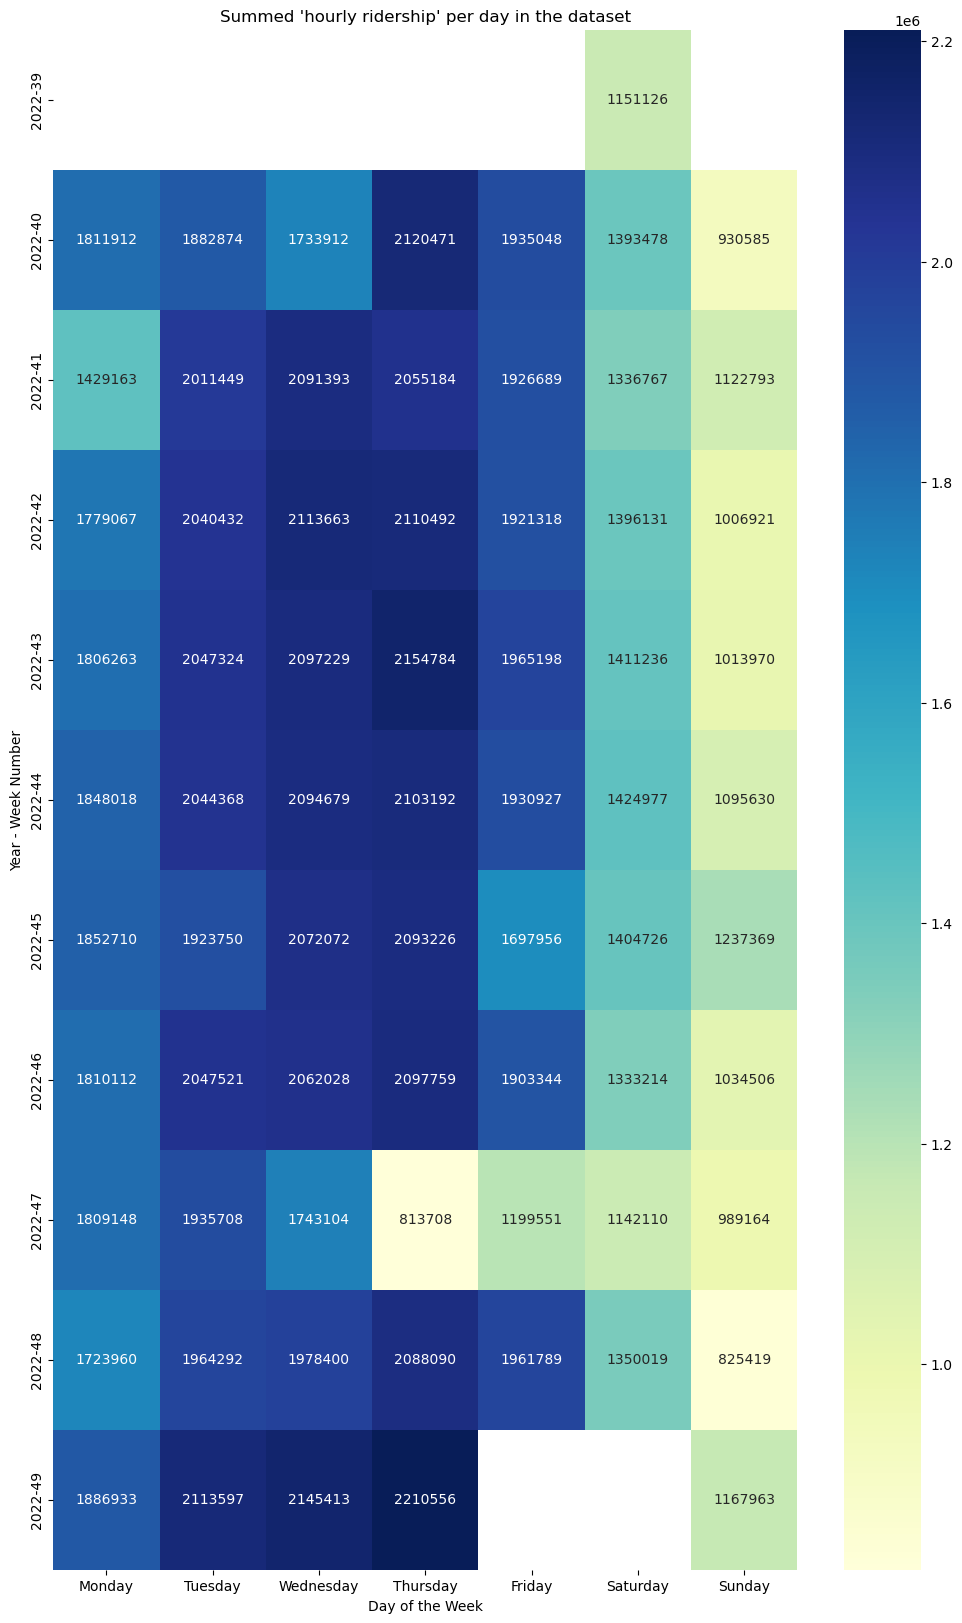

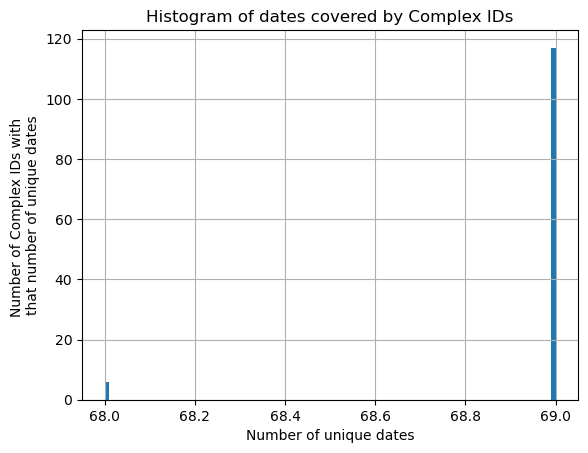

/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/IPython/core/display.py:431: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [19]:
from datetime import datetime, timedelta
# Analysis from 9th - 39th week of 2022

start = datetime(2022,10,1)
end = datetime(2022,12,9)
print('Filtering data from ', start, ' to ', end)

df_manhattan_filtered = df_manhattan[
    (df_manhattan['transit_timestamp'] >= start) & 
    (df_manhattan['transit_timestamp'] < end)
]




df_ridership = df_manhattan_filtered.set_index('transit_timestamp')[['ridership']]
df_ridership = df_ridership.resample('d').sum()
start = df_ridership.index.min()
end = df_ridership.index.max()
ridership_per_hours = df_ridership.reindex(pd.date_range(start=start, end=end, freq='d')).fillna(0)

df = ridership_per_hours.copy().reset_index()
df['day'] = df['index'].dt.day_name()
df['week_year'] = df['index'].dt.strftime('%Y-%U')
df_pivot = df.pivot(index='week_year', columns='day', values='ridership')
df_pivot = df_pivot[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]


plt.figure(figsize=(12, 20))
sns.heatmap(df_pivot, cmap='YlGnBu', annot=True,
            fmt=".0f"
           )  # Set color bar format to scientific notation


plt.title("Summed 'hourly ridership' per day in the dataset")
plt.xlabel("Day of the Week")
plt.ylabel("Year - Week Number")
plt.show()




n_dates_per_stations =  df_manhattan_filtered.groupby('station_complex_id')['transit_timestamp'].apply(lambda s: len(s.dt.date.unique()))
n_dates_per_stations.hist(bins=100)
plt.title("Histogram of dates covered by Complex IDs")
plt.xlabel("Number of unique dates")
plt.ylabel("Number of Complex IDs with \nthat number of unique dates")
plt.show()


gdf_from_flows = gpd.GeoDataFrame(df_manhattan_filtered.groupby('station_complex_id').agg({'latitude': 'first',
                                                                                      'longitude': 'first',
                                                                                      'ridership': 'sum',
                                                                                      })
                                                                                      )
gdf_from_flows = gdf_from_flows.set_geometry(gpd.points_from_xy(gdf_from_flows.longitude, gdf_from_flows.latitude))
gdf_from_flows.crs = 'EPSG:4326'

gdf_from_flows['ridership_100k'] = gdf_from_flows['ridership'] / 1000000

m = gdf_from_flows.explore('ridership_100k',
        tiles = 'CartoDB positron', 
        marker_type = 'circle',
        style_kwds={'style_function': lambda x: {'radius': np.sqrt(x['properties']['ridership'])/30},
                        'cmap': 'viridis',
                        'fill': True,
                    },
        legend_kwds={'caption': 'Ridership in Millions'}
        )

map_html_string = m._repr_html_()
escaped_map_html = html.escape(map_html_string, quote=True)
iframe_html = f'<iframe srcdoc="{escaped_map_html}" width="{800}" height="{400}" style="border:none;"></iframe>'
display(HTML(iframe_html))